In [5]:
import numpy as np
from matplotlib import colors
import matplotlib.pyplot as plt
import thinker
import thinker.viz_utils as viz
import thinker.util as util
import gym
import gym_sokoban
import os
import torch

In [2]:
def plot_mini_sokoban(state, legend=False, unqtar=False, unqbox=False):
    """Plot board state for mini sokoban

    Args:
        state (numpy.ndarray): 8x8x7 array representing board
        legend (bool, optional): if True, include legend explaining colours. Defaults to False.
    """
    if state.shape[0] != state.shape[1]:
        state = state.permute(1,2,0)
    if unqtar and unqbox:
        dim_z = 13
    elif unqtar:
        dim_z = 10
    else:
        dim_z = 7
    mini_board = np.zeros(state.shape[:-1])
    for i in range(1,1+dim_z):
        mini_board[(state[:,:,i-1] == 1)] = i
    mini_board = np.flip(mini_board, axis=0)
    #print(mini_board)
    if unqtar and unqbox:
        cmap = colors.ListedColormap(['black', "white", "aqua", "gold", "hotpink","magenta", "khaki", "grey", "yellow", "purple", "lime", "brown", "turquoise", "coral", "peru"])
        labs = ["wall", "empty", "box1", "box-on-target?", "player","player-on-target?", "target1", "target2", "target3", "target4", "box2", "box3", "box4"]
    elif unqtar:
        cmap = colors.ListedColormap(['black', "white", "aqua", "gold", "green","magenta", "khaki", "grey", "yellow", "purple", "lime"])
        labs = ["wall", "empty", "box", "box-on-target?", "player","player-on-target?", "target1", "target2", "target3", "target4"]
    else:
        cmap = colors.ListedColormap(['black', "white", "aqua", "gold", "green","magenta", "khaki"])
        labs = ["wall", "empty", "box", "box-on-target?", "player","player-on-target?", "target"]
    bounds= [i+0.5 for i in range(1+dim_z)]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    board_img = plt.imshow(mini_board, interpolation='nearest', origin='lower', cmap=cmap, norm=norm)
    board_img.axes.get_yaxis().set_visible(False)
    board_img.axes.get_xaxis().set_visible(False)
    if legend:
        board_cbar = plt.colorbar(board_img, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds)
        board_cbar.ax.set_yticks(list(range(1,1+dim_z)))
        board_cbar.ax.tick_params(length=0)
        board_cbar_text = board_cbar.ax.set_yticklabels(labs)
    plt.show()

Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


mini=True, unqtar=False, unqbox=False
mini=True, unqtar=False, unqbox=False
mini=True, unqtar=False, unqbox=False


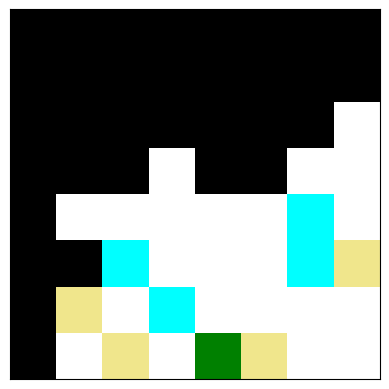

In [16]:
from thinker.actor_net import sample, DRCNet
env_n = 1
gpu = False
mini_sokoban = True 
mini_unqtar = False
mini_unqbox = False

env = thinker.make(
    "Sokoban-v0", 
    env_n=env_n, 
    gpu=gpu,
    wrapper_type=1, 
    has_model=False, 
    train_model=False, 
    parallel=False, 
    save_flags=False,
    mini=mini_sokoban,
    mini_unqtar=mini_unqtar,
    mini_unqbox=mini_unqbox         
    ) 
flags = util.create_setting(args=[], save_flags=False, wrapper_type=1) 
flags.mini = mini_sokoban
flags.mini_unqbtar = mini_unqtar
flags.mini_unqbox = mini_unqbox
drc_net = DRCNet(
    obs_space=env.observation_space,
    action_space=env.action_space,
    flags=flags,
    record_state=True,
    )
drc_net.to(env.device)

ckp_path = "../drc_mini"
ckp_path = os.path.join(util.full_path(ckp_path), "ckp_actor_realstep249000192.tar")
ckp = torch.load(ckp_path, env.device)
drc_net.load_state_dict(ckp["actor_net_state_dict"], strict=False)
rnn_state = drc_net.initial_state(batch_size=env_n, device=env.device)

# run the trained drc again
state = env.reset() 
env_out = util.init_env_out(state, flags, dim_actions=1, tuple_action=False) # this converts the state to EnvOut object that can be processed by actor
actor_out, rnn_state = drc_net(env_out, rnn_state)
plot_mini_sokoban(state["real_states"][0])

In [31]:
done = env_out.done
T, B = done.shape
x = drc_net.normalize(env_out.real_states.float())
x = torch.flatten(x, 0, 1)
x_enc = drc_net.encoder(x)
core_input = x_enc.view(*((T, B) + x_enc.shape[1:]))
core_output, rnn_state = drc_net.core(core_input, done, rnn_state, record_state=drc_net.record_state)

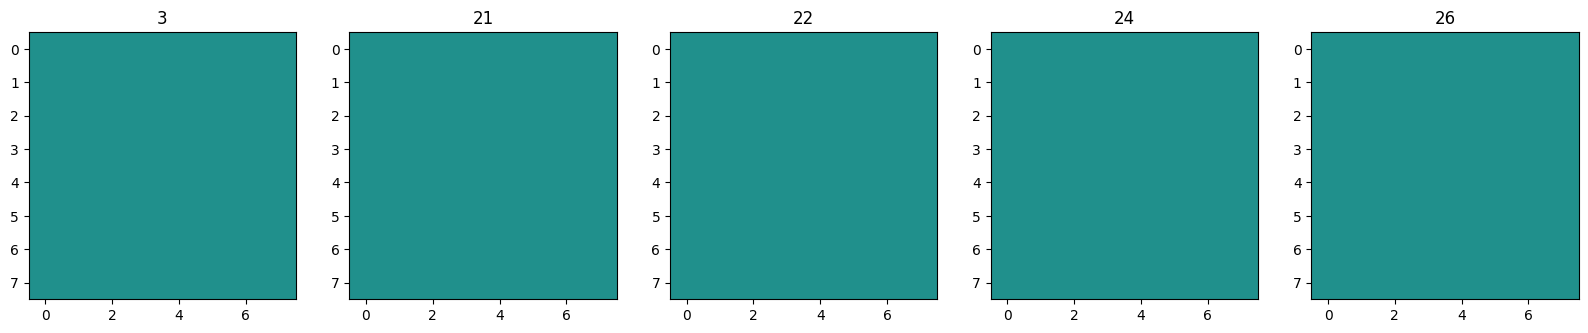

In [35]:
channels = [3, 21, 22, 24, 26]
fig, axs = plt.subplots(1,len(channels), figsize=(20,40))
for i, c in enumerate(channels):
    axs[i].imshow(core_output[0,0,c,:,:].detach(), vmin=-1,vmax=1)
    axs[i].set_title(c)

In [8]:
def do_move(move, core_output):

    assert move in ["up", "down", "left", "right"]
    
    channels = [3, 21, 22, 24, 26]
    for c in channels:
        core_output[0,0,c,:,:] = 0

    core_output[0,0,3,5,4] = -1 if move in ["down", "right"] else 1
    core_output[0,0,3,4,4] = -1 if move in ["down", "right"] else 1

    core_output[0,0,22,5,4] = -1 if move in ["down", "left"] else 1
    core_output[0,0,22,4,4] = -1 if move in ["down", "left"] else 1

    core_output[0,0,24,5,4] = -1 if move in ["down", "right"] else 1
    core_output[0,0,24,4,4] = -1 if move in ["down", "right"] else 1

    core_output[0,0,26,5,4] = 1 if move in ["down", "up"] else 1
    core_output[0,0,26,4,4] = 1 if move in ["down", "up"] else 1

In [28]:
do_move("right", core_output)

In [34]:
channels = [3, 21, 22, 24, 26]
for c in channels:
    core_output[0,0,c,:,:] = 0

In [ ]:
done = env_out.done
T, B = done.shape
x = drc_net.normalize(env_out.real_states.float())
x = torch.flatten(x, 0, 1)
x_enc = drc_net.encoder(x)
core_input = x_enc.view(*((T, B) + x_enc.shape[1:]))
core_output, rnn_state = drc_net.core(core_input, done, rnn_state, record_state=drc_net.record_state)
channels = [3, 21, 22, 24, 26]
for c in channels:
    core_output[0,0,c,:,:] = 0
final_out = torch.nn.functional.relu(drc_net.final_layer(core_output))
pri_logits = drc_net.policy(final_out)
pri_logits = pri_logits.view(T*B, drc_net.dim_actions, drc_net.num_actions)

tensor([[[-1.0280,  0.3405,  0.1035,  0.6692, -0.3769]]],
       grad_fn=<ViewBackward0>)


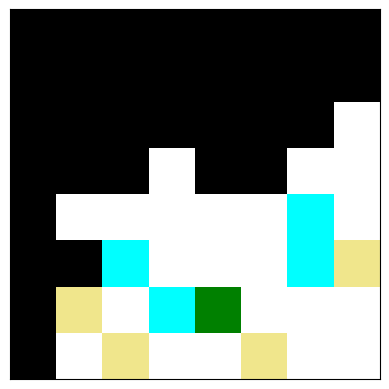

In [36]:
core_output = torch.flatten(core_output, 0, 1)
#print(core_output.shape)
core_output = torch.cat([x_enc, core_output], dim=1)
#print(core_output.shape)
core_output = torch.flatten(core_output, 1)
#print(core_output.shape)
final_out = torch.nn.functional.relu(drc_net.final_layer(core_output))
pri_logits = drc_net.policy(final_out)
pri_logits = pri_logits.view(T*B, drc_net.dim_actions, drc_net.num_actions)
pri = sample(pri_logits, greedy=True, dim=-1)
pri = pri.view(T, B, drc_net.dim_actions) 
pri_env = pri[-1, :, 0] if not drc_net.tuple_action else pri[-1]   
action = pri_env 
state, reward, done, info = env.step(action)
env_out = util.create_env_out(action, state, reward, done, info, flags)
print(pri_logits)
plot_mini_sokoban(state["real_states"][0])

In [66]:
done = env_out.done
T, B = done.shape
x = drc_net.normalize(env_out.real_states.float())
x = torch.flatten(x, 0, 1)
x_enc = drc_net.encoder(x)
core_input = x_enc.view(*((T, B) + x_enc.shape[1:]))
core_output, rnn_state = drc_net.core(core_input, done, rnn_state, record_state=drc_net.record_state)

In [55]:
x_enc.shape

torch.Size([1, 32, 8, 8])

In [59]:
#channels = [3, 21, 22, 24, 26]
channels = list(range(32))
for c in channels:
    core_output[0,0,c,:,:] = 0
    x_enc[0,c,:,:] = 0

In [62]:
results = []

tensor(0.9237, grad_fn=<SumBackward0>)

In [ ]:
channels = [3, 21, 22, 24, 26]

In [622]:
pri = sample(pri_logits, greedy=True, dim=-1)
pri = pri.view(T, B, drc_net.dim_actions) 
pri_env = pri[-1, :, 0] if not drc_net.tuple_action else pri[-1]   
action = pri_env 
state, reward, done, info = env.step(action)
env_out = util.create_env_out(action, state, reward, done, info, flags)

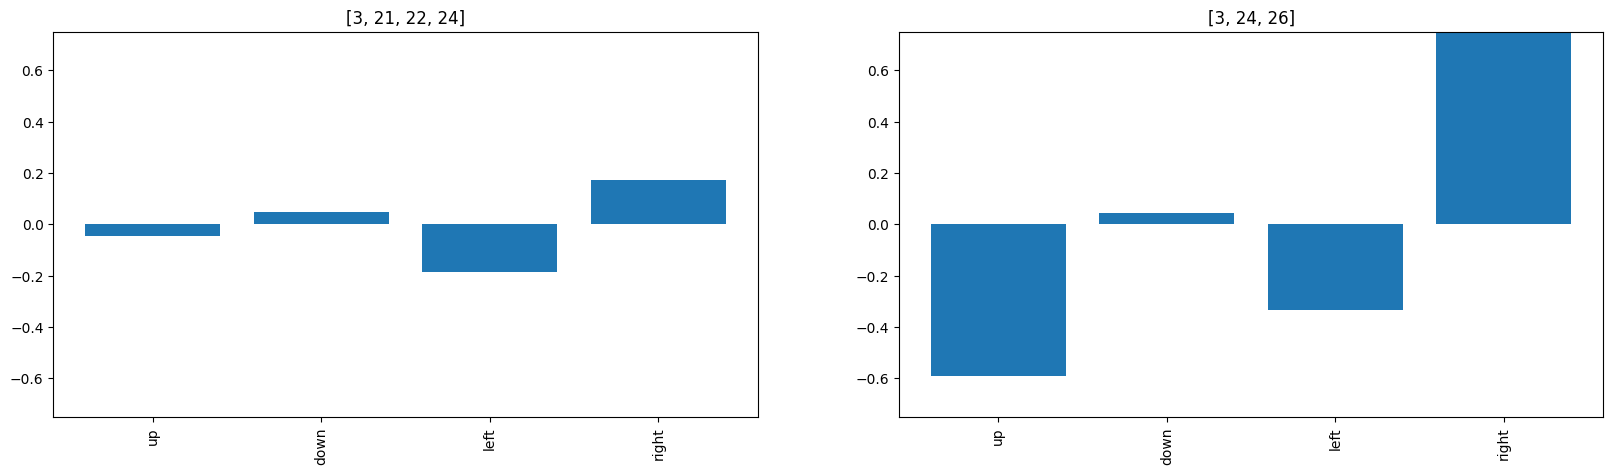

In [713]:
channels = [-1, [3,21,22,24], [3,24,26]]
results = []
for channel in channels:
    allchannels = list(range(32))
    done = env_out.done
    T, B = done.shape
    x = drc_net.normalize(env_out.real_states.float())
    x = torch.flatten(x, 0, 1)
    x_enc = drc_net.encoder(x)
    core_input = x_enc.view(*((T, B) + x_enc.shape[1:]))
    core_output, rnn_state = drc_net.core(core_input, done, rnn_state, record_state=drc_net.record_state)
    #for c in allchannels:
        #core_output[0,0,c,:,:] = 0
        #x_enc[0,c,:,:] = 0
    if channel != -1:
        core_output[0,0,channel,torch.randint(high=6, low=1, size=(1,)),torch.randint(high=6, low=1, size=(1,))] = -1
    core_output = torch.flatten(core_output, 0, 1)
    core_output = torch.cat([x_enc, core_output], dim=1)
    core_output = torch.flatten(core_output, 1)
    final_out = torch.nn.functional.relu(drc_net.final_layer(core_output))
    pri_logits = drc_net.policy(final_out)
    pri_logits = pri_logits.view(T*B, drc_net.dim_actions, drc_net.num_actions)
    results.append(pri_logits.view(-1))
fig, axs = plt.subplots(1,len(results)-1, figsize=(20,5))
for i in range(1,len(results)):
    axs[i-1].bar(x=range(4),height=(results[i]-results[0]).tolist()[1:])
    axs[i-1].set_ylim(-0.75,0.75)
    axs[i-1].set_title(channels[i] if i != 0 else "baseline")
    axs[i-1].set_xticks(range(4), ["up", "down", "left", "right"], rotation="vertical")

In [ ]:
channels = [-1, 3, 21, 22, 24, 26]
results = []
for channel in channels:
    allchannels = list(range(32))
    done = env_out.done
    T, B = done.shape
    x = drc_net.normalize(env_out.real_states.float())
    x = torch.flatten(x, 0, 1)
    x_enc = drc_net.encoder(x)
    core_input = x_enc.view(*((T, B) + x_enc.shape[1:]))
    core_output, rnn_state = drc_net.core(core_input, done, rnn_state, record_state=drc_net.record_state)
    #for c in allchannels:
        #core_output[0,0,c,:,:] = 0
        #x_enc[0,c,:,:] = 0
    if channel != -1:
        core_output[0,0,channel,torch.randint(high=7, low=0, size=(2,)),torch.randint(high=7, low=0, size=(2,))] = 1
    core_output = torch.flatten(core_output, 0, 1)
    core_output = torch.cat([x_enc, core_output], dim=1)
    core_output = torch.flatten(core_output, 1)
    final_out = torch.nn.functional.relu(drc_net.final_layer(core_output))
    pri_logits = drc_net.policy(final_out)
    pri_logits = pri_logits.view(T*B, drc_net.dim_actions, drc_net.num_actions)
    results.append(pri_logits.view(-1))
fig, axs = plt.subplots(1,len(results)-1, figsize=(20,5))
for i in range(1,len(results)):
    axs[i-1].bar(x=range(4),height=(results[i]-results[0]).tolist()[1:])
    axs[i-1].set_ylim(-0.75,0.75)
    axs[i-1].set_title(channels[i] if i != 0 else "baseline")
    axs[i-1].set_xticks(range(4), ["up", "down", "left", "right"], rotation="vertical")

In [88]:
torch.randint(high=7, low=0, size=(1,)).item()

0

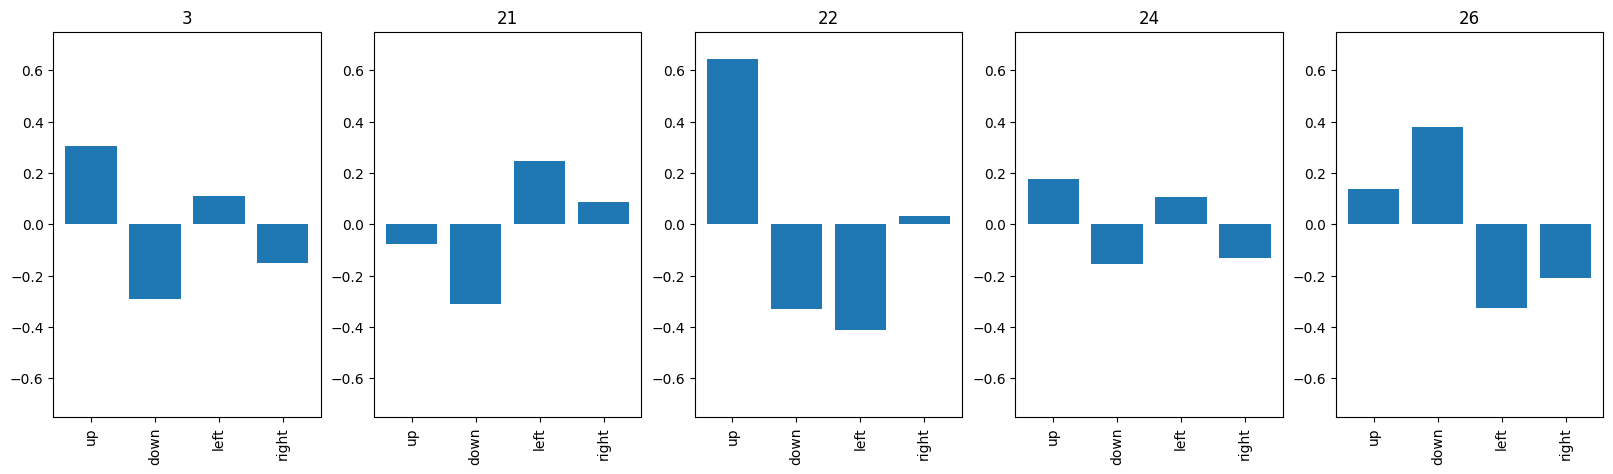

In [108]:
fig, axs = plt.subplots(1,len(results)-1, figsize=(20,5))
for i in range(1,len(results)):
    axs[i-1].bar(x=range(4),height=(results[i]-results[0]).tolist()[1:])
    axs[i-1].set_ylim(-0.75,0.75)
    axs[i-1].set_title(channels[i] if i != 0 else "baseline")
    axs[i-1].set_xticks(range(4), ["up", "down", "left", "right"], rotation="vertical")

In [719]:
weights = drc_net.final_layer.weight.view(256,64,8,8)

In [720]:
def plot_hidden_weights(n, weights, vmin, vmax):
    channels = list(range(32,48))
    fig, axs = plt.subplots(2,len(channels), figsize=(20,3))
    for i, c in enumerate(channels):
        axs[0,i].imshow(weights[n,c,:,:].detach(), vmin=vmin,vmax=vmax)
        axs[0,i].set_title(c-32)
        axs[0,i].get_yaxis().set_visible(False)
        axs[0,i].get_xaxis().set_visible(False)
    channels = list(range(48,64))
    for i, c in enumerate(channels):
        axs[1,i].imshow(weights[n,c,:,:].detach(), vmin=vmin,vmax=vmax)
        axs[1,i].set_title(c-32)
        axs[1,i].get_yaxis().set_visible(False)
        axs[1,i].get_xaxis().set_visible(False)
    plt.show()

def plot_hidden_weights_many(ns, weights, vmin, vmax):
    fig, axs = plt.subplots(2*len(ns),16, figsize=(20,3*len(ns)))
    for j, n in enumerate(ns):
        channels = list(range(32,48))
        for i, c in enumerate(channels):
            axs[2*j,i].imshow(weights[n,c,:,:].detach(), vmin=vmin,vmax=vmax)
            axs[2*j,i].set_title(f"n={n},c={c-32}")
            axs[2*j,i].get_yaxis().set_visible(False)
            axs[2*j,i].get_xaxis().set_visible(False)
        channels = list(range(48,64))
        for i, c in enumerate(channels):
            axs[2*j+1,i].imshow(weights[n,c,:,:].detach(), vmin=vmin,vmax=vmax)
            axs[2*j+1,i].set_title(f"n={n},c={c-32}")
            axs[2*j+1,i].get_yaxis().set_visible(False)
            axs[2*j+1,i].get_xaxis().set_visible(False)
    plt.show()

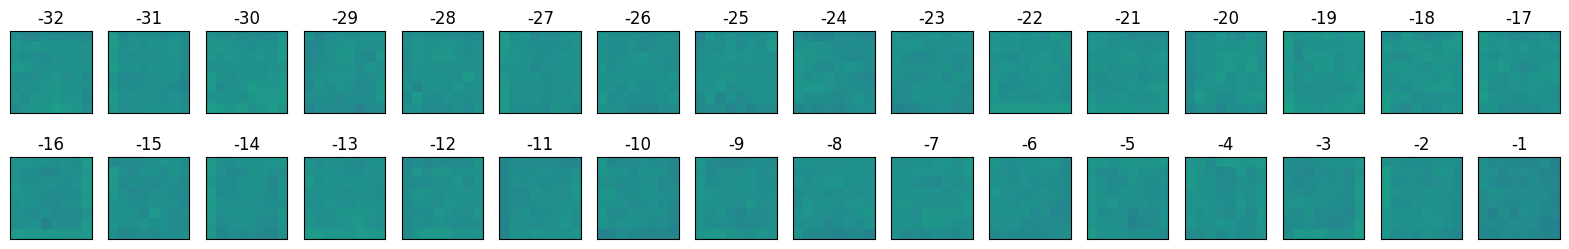

In [721]:
n = 10
channels = list(range(16))
fig, axs = plt.subplots(2,len(channels), figsize=(20,3))
for i, c in enumerate(channels):
    axs[0,i].imshow(weights[n,c,:,:].detach(), vmin=-1,vmax=1)
    axs[0,i].set_title(c-32)
    axs[0,i].get_yaxis().set_visible(False)
    axs[0,i].get_xaxis().set_visible(False)
channels = list(range(16,32))
for i, c in enumerate(channels):
    axs[1,i].imshow(weights[n,c,:,:].detach(), vmin=-1,vmax=1)
    axs[1,i].set_title(c-32)
    axs[1,i].get_yaxis().set_visible(False)
    axs[1,i].get_xaxis().set_visible(False)
plt.show()


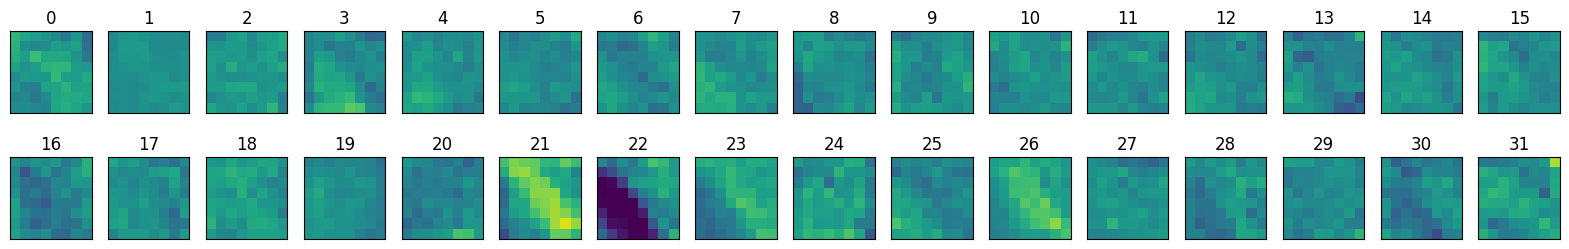

In [722]:
n = 0
channels = list(range(32,48))
fig, axs = plt.subplots(2,len(channels), figsize=(20,3))
for i, c in enumerate(channels):
    axs[0,i].imshow(weights[n,c,:,:].detach(), vmin=-1,vmax=1)
    axs[0,i].set_title(c-32)
    axs[0,i].get_yaxis().set_visible(False)
    axs[0,i].get_xaxis().set_visible(False)
channels = list(range(48,64))
for i, c in enumerate(channels):
    axs[1,i].imshow(weights[n,c,:,:].detach(), vmin=-1,vmax=1)
    axs[1,i].set_title(c-32)
    axs[1,i].get_yaxis().set_visible(False)
    axs[1,i].get_xaxis().set_visible(False)
plt.show()

In [169]:
drc_net.policy.weight.detach()[0,:].argmax()

tensor(215)

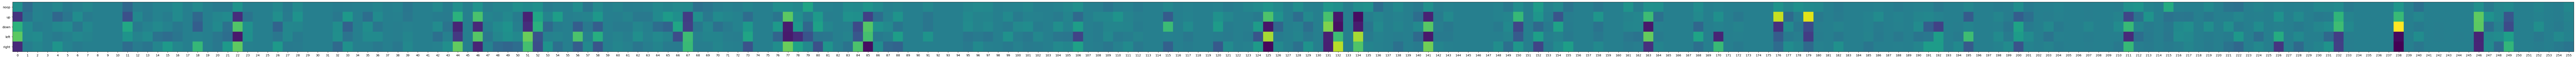

In [310]:
fig, axs = plt.subplots(figsize=(150,50))
axs.imshow(drc_net.policy.weight.detach())
axs.set_xticks(range(256))
axs.set_yticks(range(5), labels=["noop", "up", "down", "left", "right"])
plt.show()

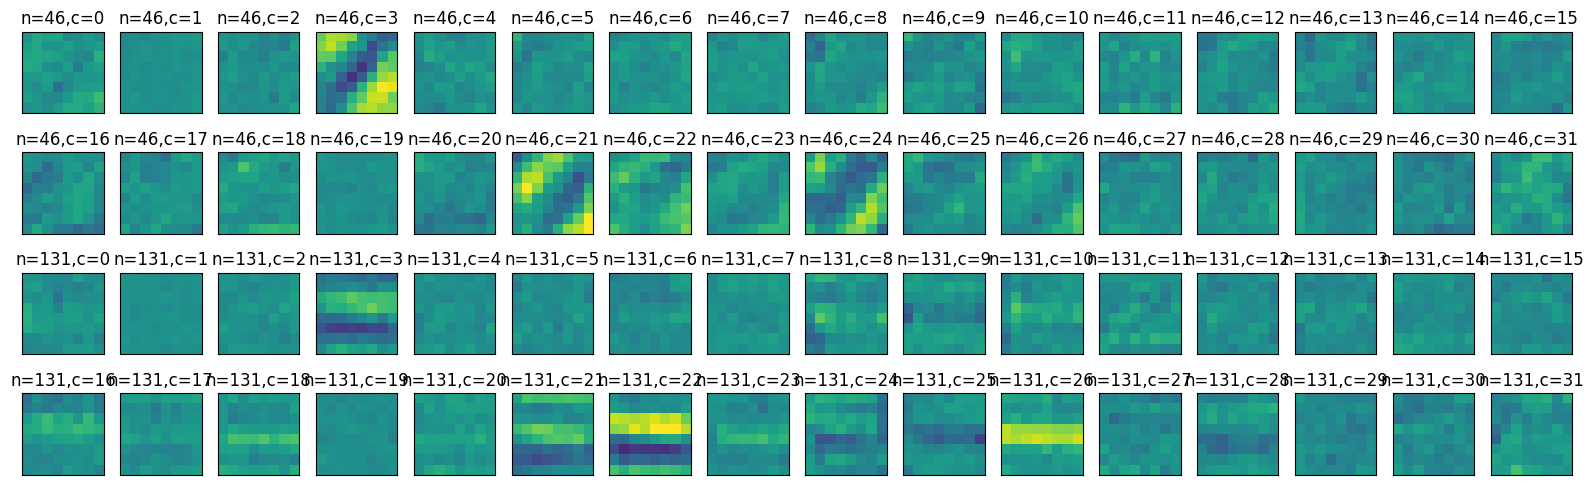

In [312]:
plot_hidden_weights_many([46, 131],weights, vmin=-1.2, vmax=1.2)

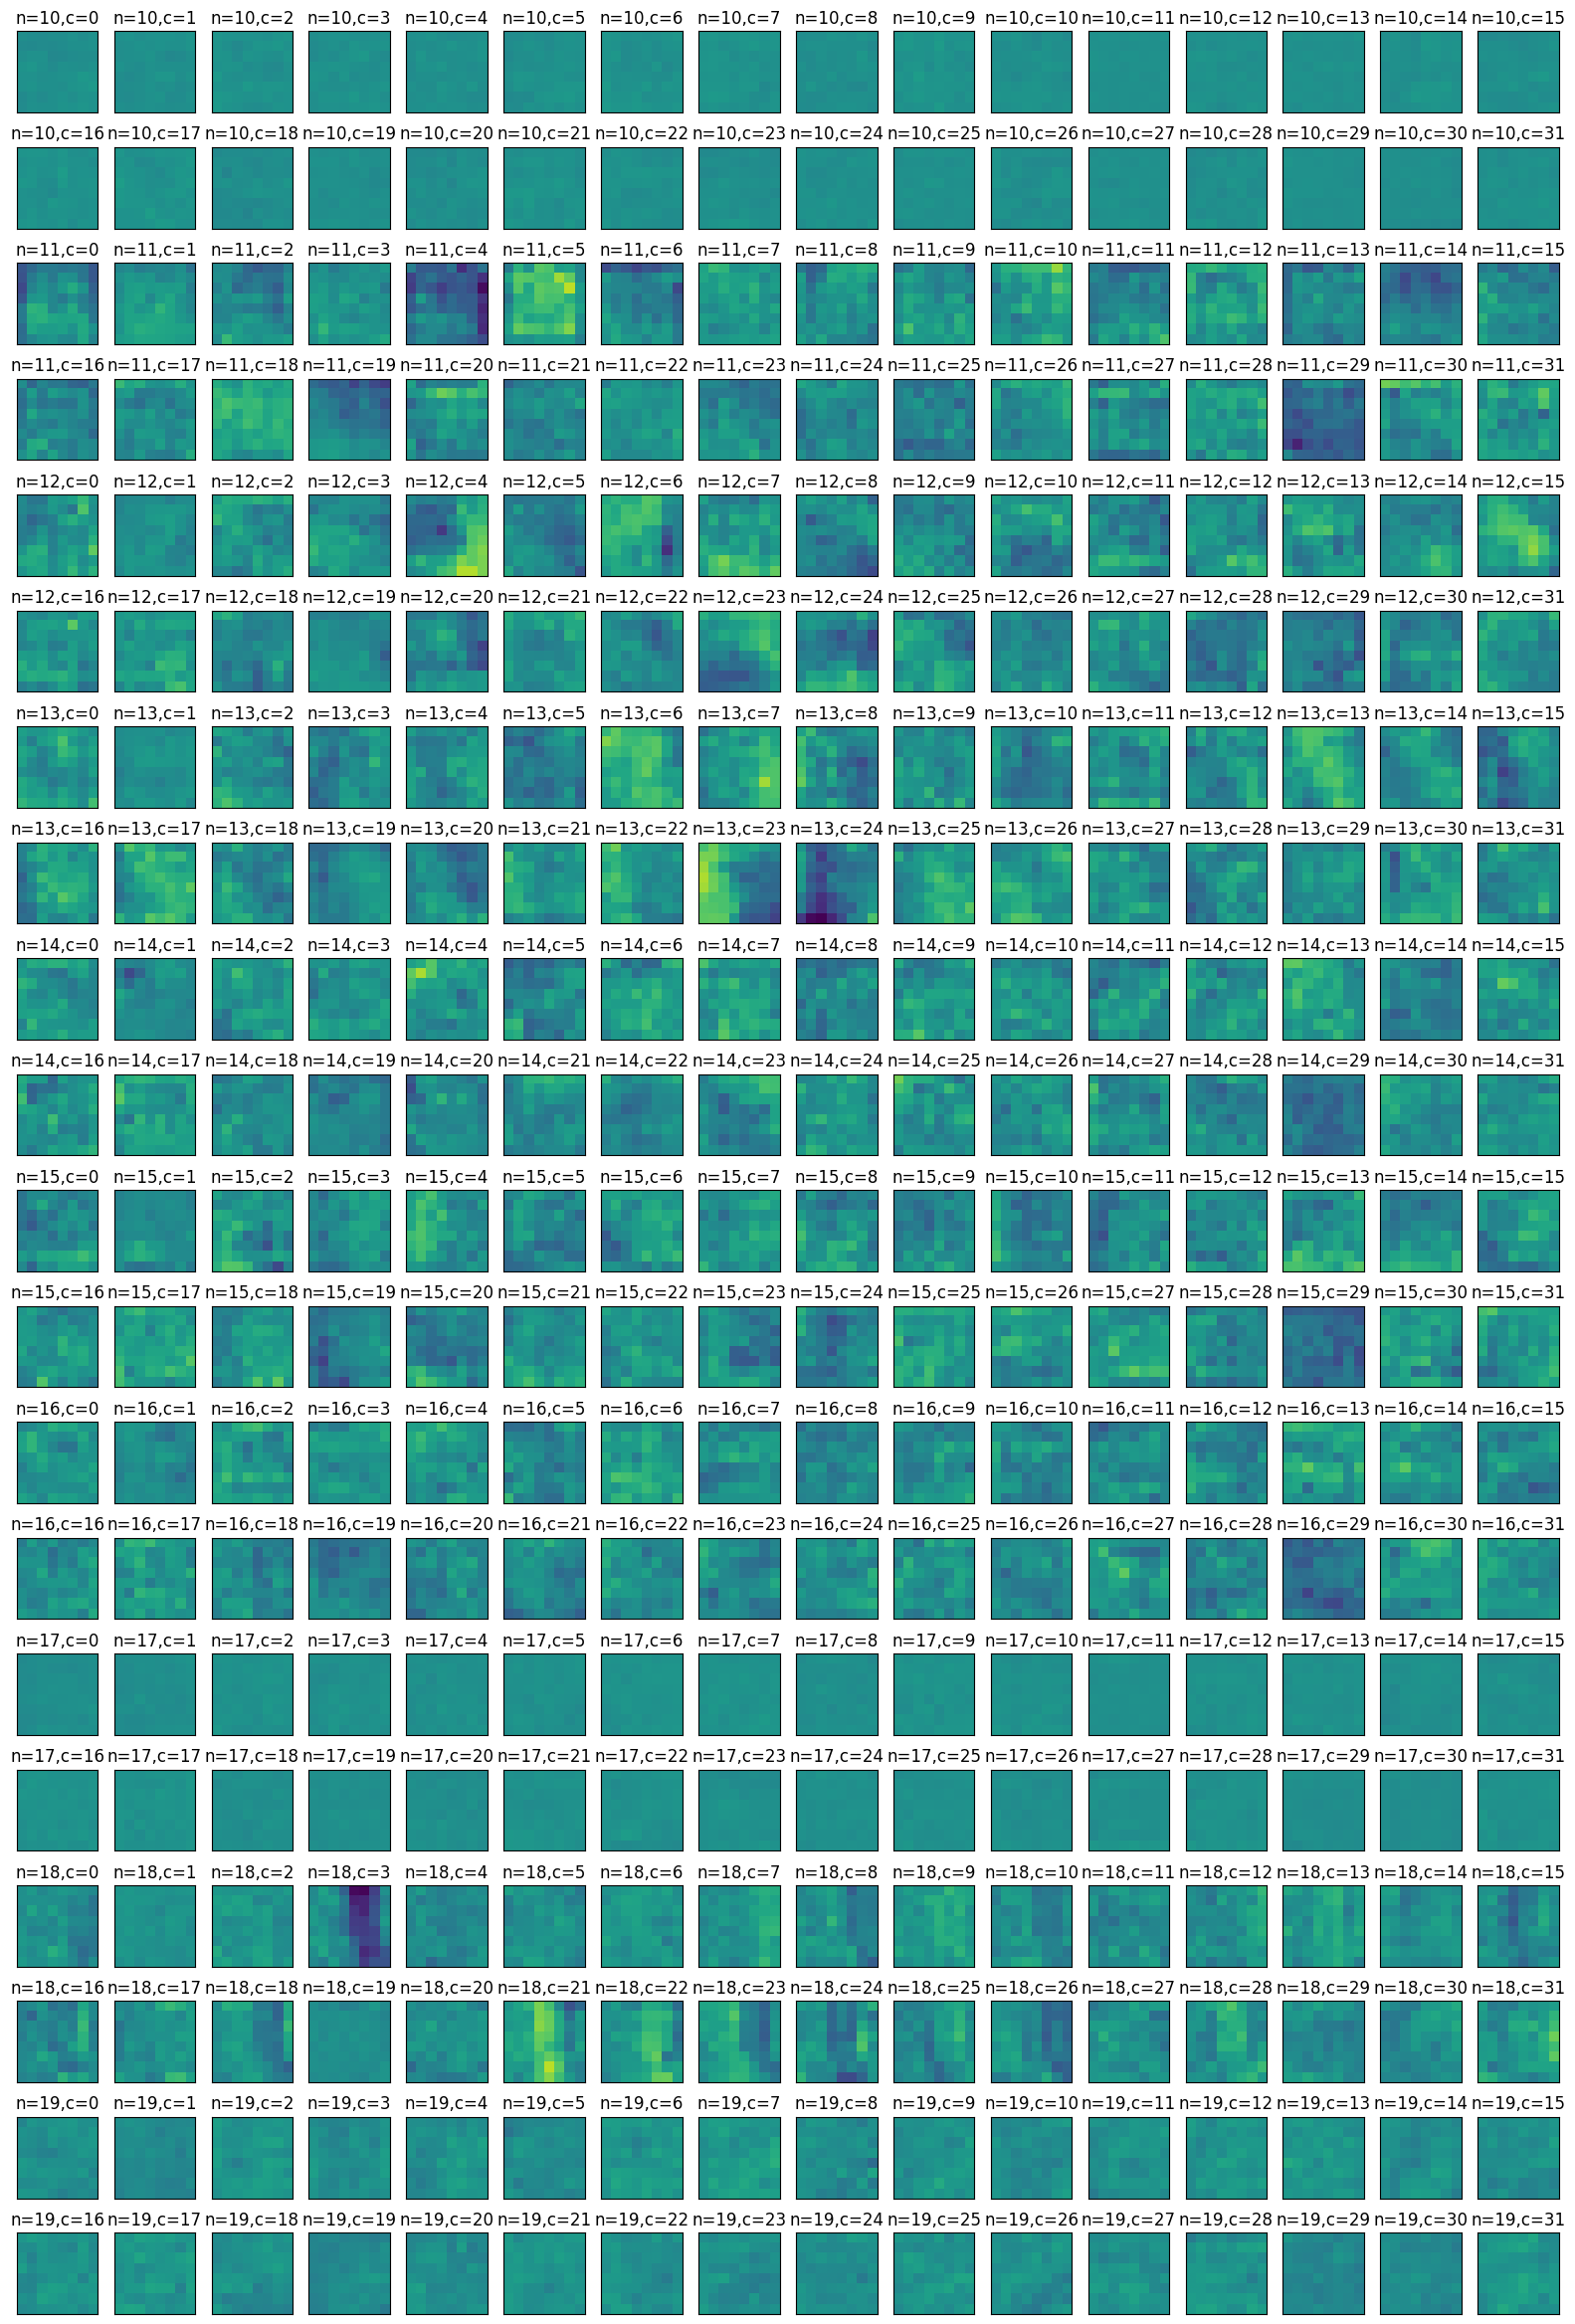

In [162]:
plot_hidden_weights_many(list(range(10,20)),weights, vmin=-1.2, vmax=1.2)

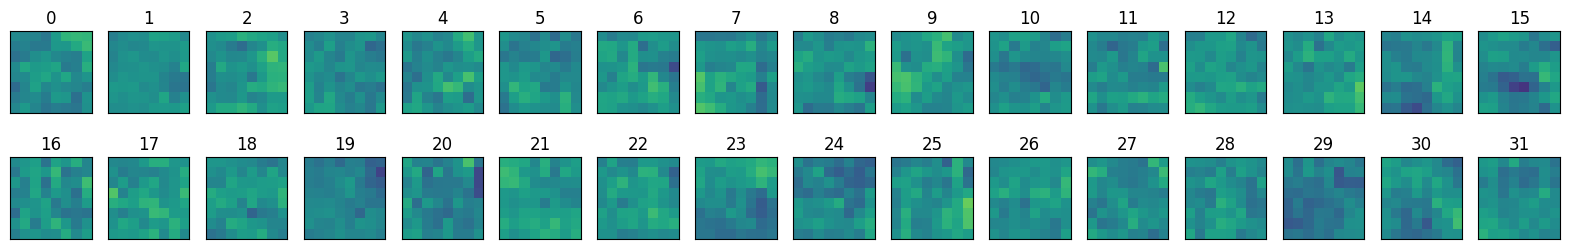

In [311]:
plot_hidden_weights(2,weights, vmin=-1.2, vmax=1.2)

In [723]:
def plot_hidden_weights_sum(weights, vmin, vmax):
    channels = list(range(32,48))
    fig, axs = plt.subplots(2,len(channels), figsize=(20,3))
    for i, c in enumerate(channels):
        axs[0,i].imshow(weights[c,:,:].detach(), vmin=vmin,vmax=vmax)
        axs[0,i].set_title(c-32)
        axs[0,i].get_yaxis().set_visible(False)
        axs[0,i].get_xaxis().set_visible(False)
    channels = list(range(48,64))
    for i, c in enumerate(channels):
        axs[1,i].imshow(weights[c,:,:].detach(), vmin=vmin,vmax=vmax)
        axs[1,i].set_title(c-32)
        axs[1,i].get_yaxis().set_visible(False)
        axs[1,i].get_xaxis().set_visible(False)
    plt.show()

In [192]:
(weights.T * drc_net.policy.weight.detach()[1,:]).T.shape

torch.Size([256, 64, 8, 8])

In [197]:
(weights.T * drc_net.policy.weight.detach()[1,:]).T.sum(dim=0).shape

torch.Size([64, 8, 8])

In [185]:
drc_net.policy.weight.detach()[1,:].shape

torch.Size([256])

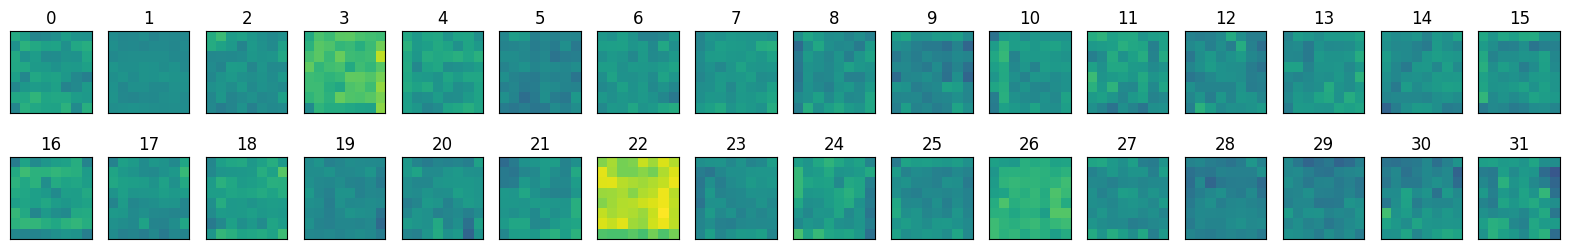

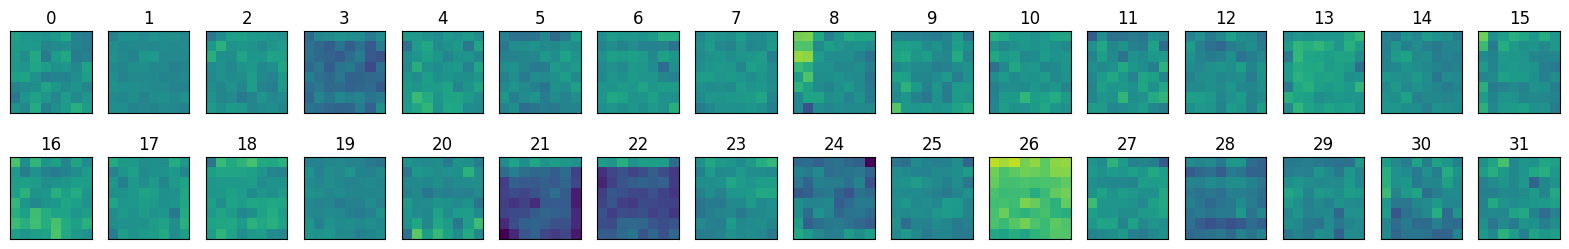

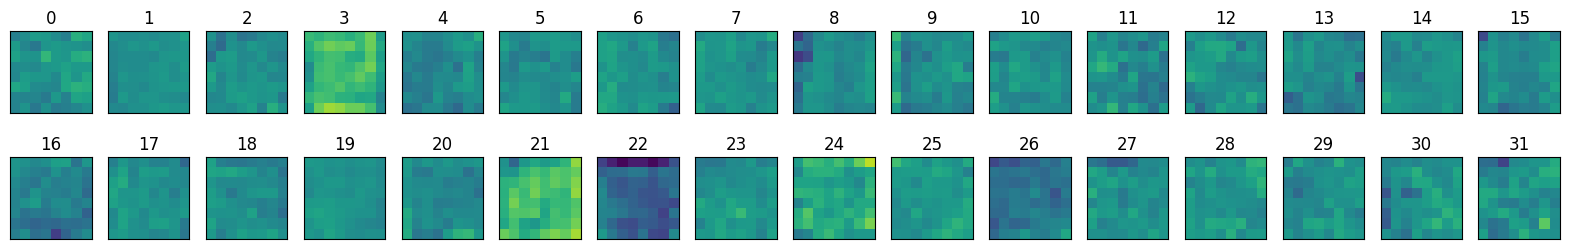

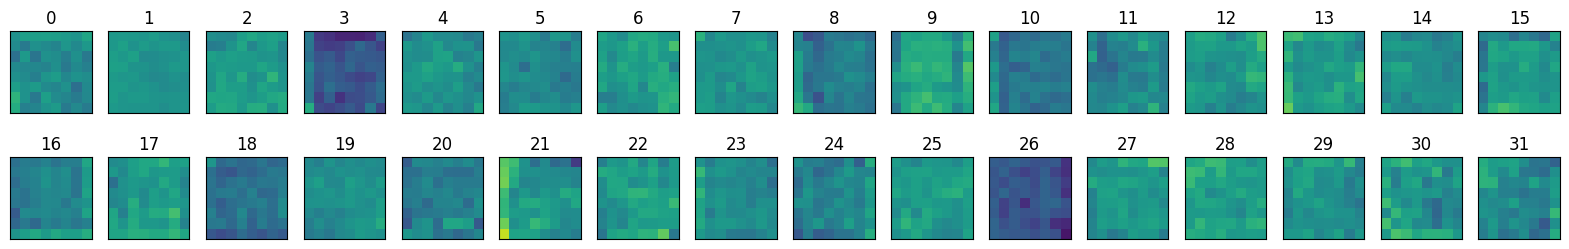

In [752]:
for i in range (1,5):
    plot_hidden_weights_sum((weights.T * drc_net.policy.weight.detach()[i,:]).T.sum(dim=0),-1,1)